In [ ]:
pip install segmentation-models

In [ ]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)


In [ ]:
%env SM_FRAMEWORK=tf.keras


env: SM_FRAMEWORK=tf.keras


In [ ]:
import segmentation_models as sm
from segmentation_models import PSPNet, Linknet, FPN
from segmentation_models import get_preprocessing
from segmentation_models.losses import jaccard_loss,dice_loss
from segmentation_models.metrics import iou_score, precision
import glob
import os
import cv2
import numpy as np
import h5py
import tensorflow as tf
from PIL import Image
import random
import matplotlib.pyplot as plt

In [ ]:
BACKBONE = 'resnext50'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
SIZE = 384
train_images = []
train_masks = []

In [ ]:
image_dataset = []
mask_dataset = []

In [ ]:
image_directory = '/content/drive/MyDrive/Papsynth/dataset/Augmented/Image/'
mask_directory = '/content/drive/MyDrive/Papsynth/dataset/Augmented/Mask/'

In [ ]:
image = os.listdir(image_directory)
image.sort()
for i, image_name in enumerate(image):
    if (image_name.split('.')[1] == 'tif'):
        im = cv2.imread(image_directory+image_name, 1)
        im = cv2.resize(im, (SIZE, SIZE))
        train_images.append(im)
train_images = np.array(train_images)

In [ ]:
masks = os.listdir(mask_directory)
masks.sort()
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = cv2.resize(image, (SIZE, SIZE))
        train_masks.append(image)
train_masks = np.array(train_masks).astype(np.float32)


In [ ]:
print(train_images.shape)
print(train_masks.shape)


(300, 384, 384, 3)
(300, 384, 384)


In [ ]:
X = train_images
Y = train_masks

#Y = np.expand_dims(Y, axis=3)

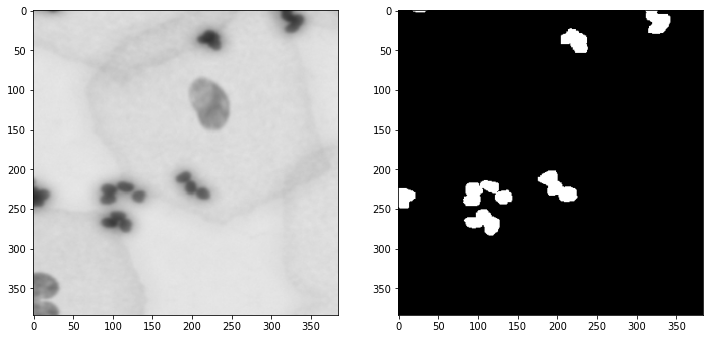

In [ ]:
image_number = random.randint(0, len(X))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X[image_number], cmap='gray')
plt.subplot(122)
plt.imshow(Y[image_number], cmap='gray')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [ ]:
model = sm.Unet(BACKBONE, input_shape=(SIZE, SIZE, 3),classes=1, encoder_weights='imagenet')
model.compile('Adam', loss=[jaccard_loss,dice_loss], metrics=[iou_score, precision])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 384, 384, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 390, 390, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 192, 192, 64) 9408        zero_padding2d_18[0][0]          
____________________________________________________________________________________________

In [ ]:
history=model.fit(x_train, 
          y_train,
          batch_size=4, 
          epochs=200,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/200
60/60 [==============================] - 59s 517ms/step - loss: 0.6167 - iou_score: 0.3833 - precision: 0.3964 - val_loss: 0.8608 - val_iou_score: 0.1392 - val_precision: 0.1448
Epoch 2/200
60/60 [==============================] - 28s 463ms/step - loss: 0.1946 - iou_score: 0.8054 - precision: 0.8643 - val_loss: 0.9094 - val_iou_score: 0.0906 - val_precision: 0.1440
Epoch 3/200
60/60 [==============================] - 26s 438ms/step - loss: 0.1618 - iou_score: 0.8382 - precision: 0.8994 - val_loss: 0.8926 - val_iou_score: 0.1074 - val_precision: 0.1456
Epoch 4/200
60/60 [==============================] - 26s 441ms/step - loss: 0.1546 - iou_score: 0.8454 - precision: 0.9073 - val_loss: 0.1724 - val_iou_score: 0.8276 - val_precision: 0.8673
Epoch 5/200
60/60 [==============================] - 28s 461ms/step - loss: 0.1494 - iou_score: 0.8506 - precision: 0.9117 - val_loss: 0.1576 - val_iou_score: 0.8424 - val_precision: 0.9036
Epoch 6/200
60/60 [==============================]

In [ ]:
accuracy = model.evaluate(x_val, y_val)

2/2 [==============================] - 15s 5s/step - loss: 0.1486 - iou_score: 0.8513 - precision: 0.9093


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Papsynth/psp_resnet.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Papsynth/psp_resnet.h5', compile=False)

In [ ]:
test_img = cv2.imread('/content/drive/MyDrive/Papsynth/dataset/test/img_41_01_01.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE, SIZE))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

In [ ]:
prediction = model.predict(test_img)
prediction_image = prediction.reshape(image.shape)

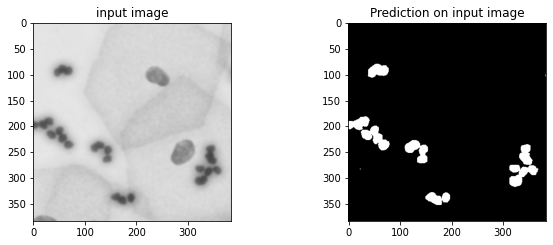

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('input image')
plt.imshow(np.squeeze(test_img), cmap='gray')
#plt.subplot(232)
#plt.title('Ground truth')
#img = cv2.imread('C:/Users/sudee/Desktop/New folder (5)/Augmented/2/m/1992.tif')
#img = cv2.resize(img, (SIZE, SIZE))
#plt.imshow(img, cmap='gray')
plt.subplot(232)
plt.title('Prediction on input image')
plt.imshow(prediction_image, cmap='gray')
plt.show()